# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Read-imcat-output-final.cat" data-toc-modified-id="Read-imcat-output-final.cat-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read imcat output final.cat</a></div><div class="lev1 toc-item"><a href="#Create-new-columns" data-toc-modified-id="Create-new-columns-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create new columns</a></div><div class="lev1 toc-item"><a href="#Fitting-cubic-function-without-bucketing-for-flux-vs-gm**2" data-toc-modified-id="Fitting-cubic-function-without-bucketing-for-flux-vs-gm**2-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fitting cubic function without bucketing for flux vs gm**2</a></div><div class="lev1 toc-item"><a href="#Fitting-cubic-function-without-bucketing-for-flux-vs-gc**2" data-toc-modified-id="Fitting-cubic-function-without-bucketing-for-flux-vs-gc**2-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fitting cubic function without bucketing for flux vs gc**2</a></div><div class="lev1 toc-item"><a href="#Fitting-cubic-function-after-bucketing" data-toc-modified-id="Fitting-cubic-function-after-bucketing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Fitting cubic function after bucketing</a></div><div class="lev1 toc-item"><a href="#Polynomial-Fitting-for-gm-vs-flux-after-bucketing" data-toc-modified-id="Polynomial-Fitting-for-gm-vs-flux-after-bucketing-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Polynomial Fitting for gm vs flux after bucketing</a></div><div class="lev1 toc-item"><a href="#Polynomial-fitting-for-gc-vs-flux-after-bucketing" data-toc-modified-id="Polynomial-fitting-for-gc-vs-flux-after-bucketing-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Polynomial fitting for gc vs flux after bucketing</a></div><div class="lev1 toc-item"><a href="#Outputs" data-toc-modified-id="Outputs-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Outputs</a></div>

# Introduction

Date: June 20, 2019

1. In jedisim we used ngals = 10k, z = 1.5 and did 100 simulations. jedisim gives l,l9,m,m9 for each 100 simulations.
2. In dmstack we create l.csv from l.fits and so on for 100*4 files, this file has 90 flags and 76 parameters.
3. After dmstack we clean and filter l.csv to get l.txt which have no nans, e <= 1.5,
   not psf candidate and have no child.
   This file has only few columns: id, x-y, errx-erry, e1-e2, sdssFlux.
4. We use these four l.txt, l9.txt, m.txt, m9.txt file in IMCAT and get final0.cat and combine 100 finalxx.cat to get 
   final.cat.
5. This lc catalog file final.cat has more columns than original 8 columns.
   ```
   id    00 10 20 30
   flux  00 10 20 30

   x  0 1
   gm 0 1
   gc 0 1
   
   errx 00 01 10 11 20 21 30 31
   g    00 01 10 11 20 21 30 31 # there is no erry here in imcat output
   
   So, in total there are
   2 * 4 + 3 * 2 + 2 * 8 = 8 + 6 + 16 = 30 columns in final.cat file.
   ```
   
   
**Purpose**  
We want to test whether the e^2 is equally distributed in different flux bins of final.cat.
We will divide flux in multiple bins and find mean(e^2) and mean(flux) for each bins and try to get a fitting function.
   

# Read imcat output final.cat

In [1]:
!head -2 final_text.txt

#       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]          gm[0]          gm[1]          gc[0]          gc[1]
            1650           1644           1649           1632       3209.807      199.77582          0.101         0.1051         0.1001          0.102         0.1021         0.1051         0.1007         0.1037         1.0922         0.0836         0.1326         0.4154         0.8654         0.0843         0.1655         0.4398      4029.9743       4050.508      4032.3095      4054.9686         0.6124         0.2495        0.51545        0.26205


In [2]:
# find number of lines
!wc -l final_text.txt

   82713 final_text.txt


In [3]:
!tail -2 final_text.txt

            2422           2403           2419           2414      3045.9086      910.89718         0.0442         0.0462         0.0424         0.0478          0.045         0.0464         0.0428         0.0479         0.0212         0.0218        -0.1339          0.206         0.0259         0.0163         -0.153         0.2034      39327.453      41065.371      39394.715      41150.748       -0.05635         0.1139       -0.06355        0.10985
            4331           4372           4356           4365      2422.9369      3224.8992         0.1032         0.1206         0.0736         0.0619         0.1029         0.1197         0.0733         0.0619        -0.3059        -0.8497         0.3844         0.7888        -0.2991        -0.8599         0.3843         0.8102      14761.931      14709.275      14763.295      14696.257        0.03925       -0.03045         0.0426       -0.02485


In [4]:
# Now we will read file using pandas

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 8]
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
# columns names
infile = 'final_text.txt'
headers = pd.read_csv(infile,sep=r'\s+',nrows=1).columns

headers = headers[1:] # remove first # column
headers

Index(['id[0][0]', 'id[1][0]', 'id[2][0]', 'id[3][0]', 'x[0]', 'x[1]',
       'errx[0][0]', 'errx[0][1]', 'errx[1][0]', 'errx[1][1]', 'errx[2][0]',
       'errx[2][1]', 'errx[3][0]', 'errx[3][1]', 'g[0][0]', 'g[0][1]',
       'g[1][0]', 'g[1][1]', 'g[2][0]', 'g[2][1]', 'g[3][0]', 'g[3][1]',
       'flux[0][0]', 'flux[1][0]', 'flux[2][0]', 'flux[3][0]', 'gm[0]',
       'gm[1]', 'gc[0]', 'gc[1]'],
      dtype='object')

In [7]:
df = pd.read_csv(infile,sep=r'\s+',comment='#',header=None)
df.columns = headers
print(df.shape)
df.head(2).append(df.tail(2)).T

(82712, 30)


,0,1,82710,82711
id[0][0],1650.00000,2741.00000,2422.00000,4331.00000
id[1][0],1644.00000,2737.00000,2403.00000,4372.00000
id[2][0],1649.00000,2733.00000,2419.00000,4356.00000
id[3][0],1632.00000,2723.00000,2414.00000,4365.00000
x[0],3209.80700,2161.57240,3045.90860,2422.93690
x[1],199.77582,1352.02110,910.89718,3224.89920
errx[0][0],0.10100,0.00080,0.04420,0.10320
errx[0][1],0.10510,0.00080,0.04620,0.12060
errx[1][0],0.10010,0.00080,0.04240,0.07360
errx[1][1],0.10200,0.00080,0.04780,0.06190


# Create new columns

In [8]:
# Find total flux, gm**2 and gc**2
df['flux'] = df['flux[0][0]'] + df['flux[1][0]'] + df['flux[2][0]'] + df['flux[3][0]']
df['gm_sq'] = df['gm[0]']**2 + df['gm[1]']**2
df['gc_sq'] = df['gc[0]']**2 + df['gc[1]']**2
df.head()

,id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],...,flux[1][0],flux[2][0],flux[3][0],gm[0],gm[1],gc[0],gc[1],flux,gm_sq,gc_sq
0,1650,1644,1649,1632,3209.80700,199.77582,0.1010,0.1051,0.1001,0.1020,...,4050.5080,4032.3095,4054.9686,0.61240,0.24950,0.51545,0.26205,1.616776e+04,0.437284,0.334359
1,2741,2737,2733,2723,2161.57240,1352.02110,0.0008,0.0008,0.0008,0.0008,...,514316.9100,514525.3600,514382.4200,-0.09310,0.25215,-0.10445,0.30695,2.057689e+06,0.072247,0.105128
2,651,646,647,641,579.18560,1409.50070,0.1755,0.1926,0.1750,0.2014,...,2062.3748,2058.1071,2060.8479,-0.40105,0.10185,-0.46155,0.11630,8.240736e+03,0.171215,0.226554
3,1425,1420,1424,1409,1478.75260,3248.40510,0.1831,0.1977,0.1869,0.1954,...,1827.7336,1823.2766,1826.9437,-0.33800,-1.00940,-0.24275,-0.94250,7.302099e+03,1.133132,0.947234
4,1341,1334,1339,1324,682.92385,3058.36250,0.1018,0.1079,0.0996,0.1122,...,3809.0571,3807.2367,3811.8982,-0.22945,-0.26680,-0.21345,-0.22875,1.523178e+04,0.123830,0.097887


In [9]:
# we want to find flux buckets, so sort the data by flux
df = df.sort_values(by='flux')
df.head(2).append(df.tail(2))

,id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],...,flux[1][0],flux[2][0],flux[3][0],gm[0],gm[1],gc[0],gc[1],flux,gm_sq,gc_sq
15057,3917,3902,3914,3898,2159.2717,2685.7977,0.7679,0.7501,0.6242,0.6446,...,6.394799e+02,5.035146e+02,5.194708e+02,0.15680,0.27785,0.1527,0.17860,2.234657e+03,0.101787,0.055215
10942,733,728,728,728,1694.2483,1710.3395,0.8146,0.7065,0.8592,0.8012,...,5.730136e+02,5.699057e+02,5.700806e+02,0.36855,-0.14700,0.4185,-0.13490,2.285642e+03,0.157438,0.193340
23562,2881,2887,2902,2886,1602.0306,1621.2151,0.0038,0.0061,0.0026,0.0031,...,9.666363e+05,1.092256e+06,9.527513e+05,-0.34560,-0.88600,-0.3315,-0.89275,4.112043e+06,0.904435,0.906895
67082,3155,3167,3135,3143,1755.4039,1936.1921,0.0015,0.0014,0.0014,0.0014,...,1.153194e+06,1.160840e+06,1.151553e+06,0.08350,-0.54890,0.0887,-0.56385,4.628740e+06,0.308263,0.325795


In [10]:
df.shape

(82712, 33)

In [11]:
df.flux.describe()

count    8.271200e+04
mean     1.165733e+05
std      2.450004e+05
min      2.234657e+03
25%      1.314300e+04
50%      2.717175e+04
75%      7.929015e+04
max      4.628740e+06
Name: flux, dtype: float64

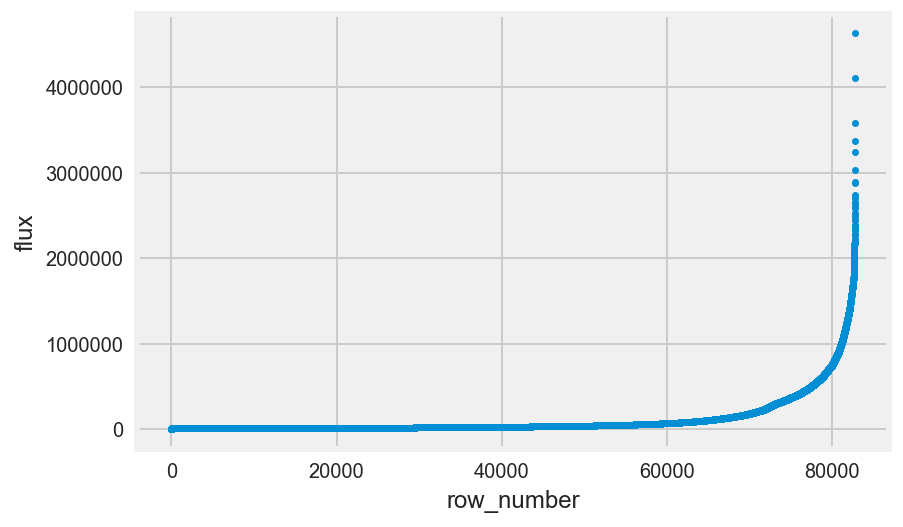

In [12]:
plt.plot(df.flux.values,'.')
plt.xlabel('row_number')
plt.ylabel('flux')

In [13]:
N_BUCKETS = 30
df['flux_bin'] = pd.cut(df.flux, bins=N_BUCKETS, labels=False)
df.head(2).append(df.tail(2)).iloc[:,-5:]

,gc[1],flux,gm_sq,gc_sq,flux_bin
15057,0.17860,2.234657e+03,0.101787,0.055215,0
10942,-0.13490,2.285642e+03,0.157438,0.193340,0
23562,-0.89275,4.112043e+06,0.904435,0.906895,26
67082,-0.56385,4.628740e+06,0.308263,0.325795,29


In [14]:
# Note that not all the bins have values
# they are divided with equal flux sum, not by number of rows.
temp = N_BUCKETS -1
df.query('flux_bin == @temp')

,id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],...,flux[2][0],flux[3][0],gm[0],gm[1],gc[0],gc[1],flux,gm_sq,gc_sq,flux_bin
67082,3155,3167,3135,3143,1755.4039,1936.1921,0.0015,0.0014,0.0014,0.0014,...,1160840.1,1151553.4,0.0835,-0.5489,0.0887,-0.56385,4628740.5,0.308263,0.325795,29


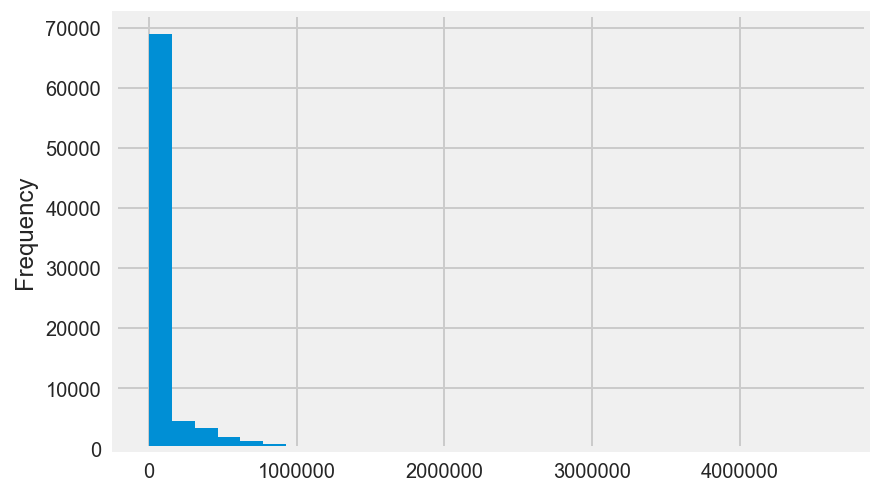

In [15]:
df.flux.plot.hist(N_BUCKETS)

In [16]:
df.iloc[:5,-5:]

,gc[1],flux,gm_sq,gc_sq,flux_bin
15057,0.17860,2234.6574,0.101787,0.055215,0
10942,-0.13490,2285.6420,0.157438,0.193340,0
75616,-0.05850,2586.9973,1.012137,0.978875,0
64774,0.77495,2655.6433,0.784500,1.137543,0
11955,0.74055,2810.6263,0.554968,0.812662,0


# Fitting cubic function without bucketing for flux vs gm**2

array([  3.61837337e-44,  -4.98940788e-37,   2.60580272e-30,
        -6.45299565e-24,   7.74798464e-18,  -3.93319369e-12,
         3.48227044e-07,   1.87505277e-01])

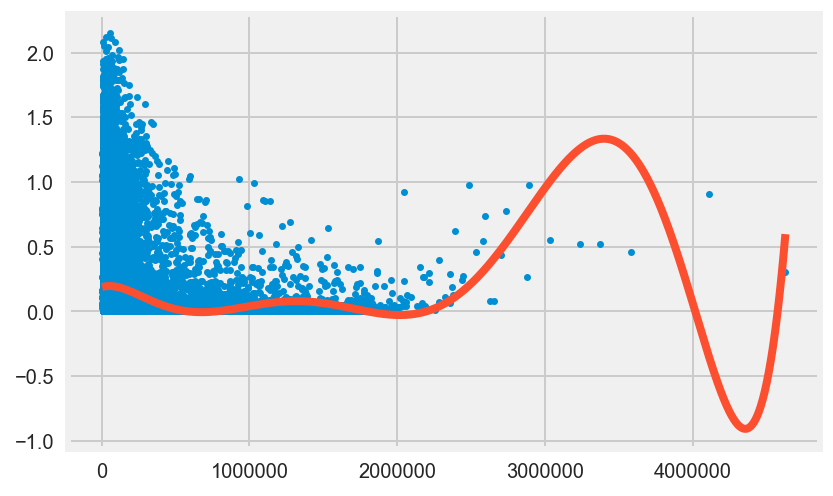

In [17]:
DEGREE = 7

x = df['flux'].values
y = df['gm_sq'].values

z = np.polyfit(x,y,DEGREE)
p = np.poly1d(z)
xp = np.linspace(x.min(), x.max(), 1000)
plt.plot(x, y, '.', xp, p(xp), '-')


gm_no_buckets = p.coeffs
gm_no_buckets

# Fitting cubic function without bucketing for flux vs gc**2

array([  3.70526103e-44,  -5.10670683e-37,   2.66446289e-30,
        -6.58539358e-24,   7.87264873e-18,  -3.94333390e-12,
         3.04939224e-07,   2.04901562e-01])

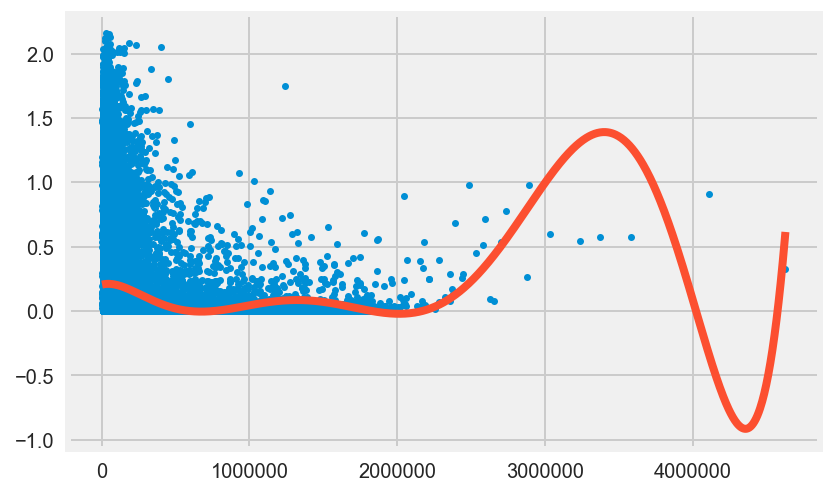

In [18]:
x = df['flux'].values
y = df['gc_sq'].values

z = np.polyfit(x,y,DEGREE)
p = np.poly1d(z)
xp = np.linspace(x.min(), x.max(), 1000)
plt.plot(x, y, '.', xp, p(xp), '-')

gc_no_buckets = p.coeffs
gc_no_buckets

# Fitting cubic function after bucketing
```
p(x) = p[0] * x**deg + ... + p[deg]
p(x) = ax**3 + bx**2 + cx + d

z = np.polyfit(x,y,3)
p = np.poly1d(z)
a = p(0)
d = p(-1)

```

In [19]:
# create new columns gm**2 gc**2 and flux for each bins
df['flux_bin_mean_gm_sq'] = df.groupby('flux_bin')['gm_sq'].transform('mean')
df['flux_bin_mean_gc_sq'] = df.groupby('flux_bin')['gc_sq'].transform('mean')
df['flux_bin_mean_flux'] = df.groupby('flux_bin')['flux'].transform('mean')
df.iloc[:5,-8:]

,gc[1],flux,gm_sq,gc_sq,flux_bin,flux_bin_mean_gm_sq,flux_bin_mean_gc_sq,flux_bin_mean_flux
15057,0.17860,2234.6574,0.101787,0.055215,0,0.194514,0.210469,33458.414473
10942,-0.13490,2285.6420,0.157438,0.193340,0,0.194514,0.210469,33458.414473
75616,-0.05850,2586.9973,1.012137,0.978875,0,0.194514,0.210469,33458.414473
64774,0.77495,2655.6433,0.784500,1.137543,0,0.194514,0.210469,33458.414473
11955,0.74055,2810.6263,0.554968,0.812662,0,0.194514,0.210469,33458.414473


In [20]:
# confirm first bin values
bin1 = df.query('flux_bin == 0')
bin1.gm_sq.mean()

0.19451413262523234

In [21]:
# look at number of rows in each bin
df['flux_bin'].value_counts()  # there are no flux values in bin #24, #28

0     68852
1      4651
2      3420
3      1945
4      1235
5       731
6       487
7       388
8       341
9       236
10      200
11      141
12       36
13       13
14       11
15        9
16        4
17        4
18        2
26        1
19        1
20        1
21        1
23        1
29        1
Name: flux_bin, dtype: int64

In [22]:
df.flux_bin.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 23, 26, 29])

In [23]:
missing = [i  for i in range(N_BUCKETS) if i not in df.flux_bin.unique()]
missing

[22, 24, 25, 27, 28]

In [24]:
# take only mean gm gc flux in each buckets, and take unique values
gm_gc_flux = df[['flux_bin_mean_gm_sq', 'flux_bin_mean_gc_sq', 'flux_bin_mean_flux']].drop_duplicates()
gm_gc_flux.columns = ['gm','gc','flux']
gm_gc_flux

,gm,gc,flux
15057,0.194514,0.210469,3.345841e+04
71614,0.107529,0.116431,2.202682e+05
73252,0.037473,0.040485,3.801962e+05
52817,0.036093,0.038546,5.365722e+05
40872,0.033806,0.035346,6.930182e+05
73949,0.034446,0.038010,8.466203e+05
21535,0.036903,0.041324,1.001184e+06
41177,0.037361,0.041066,1.157884e+06
47094,0.036408,0.045556,1.313294e+06
18185,0.030513,0.032421,1.467382e+06


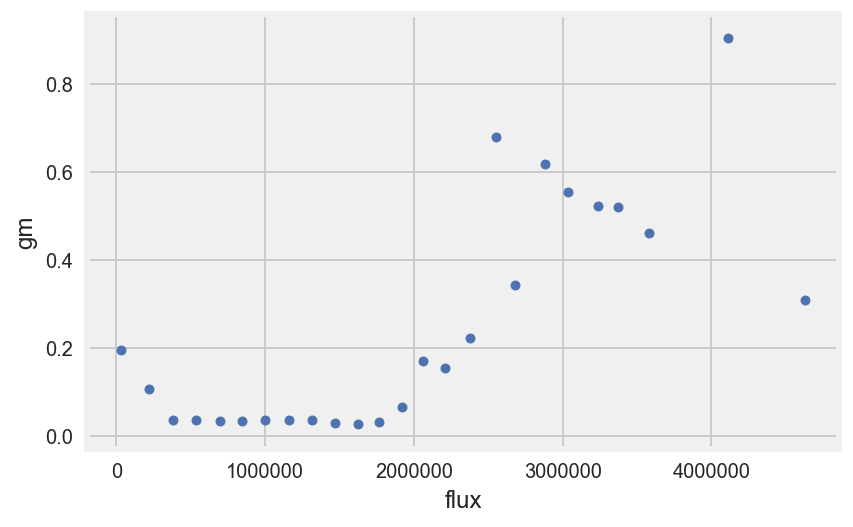

In [25]:
gm_gc_flux.plot.scatter(x='flux',y='gm')

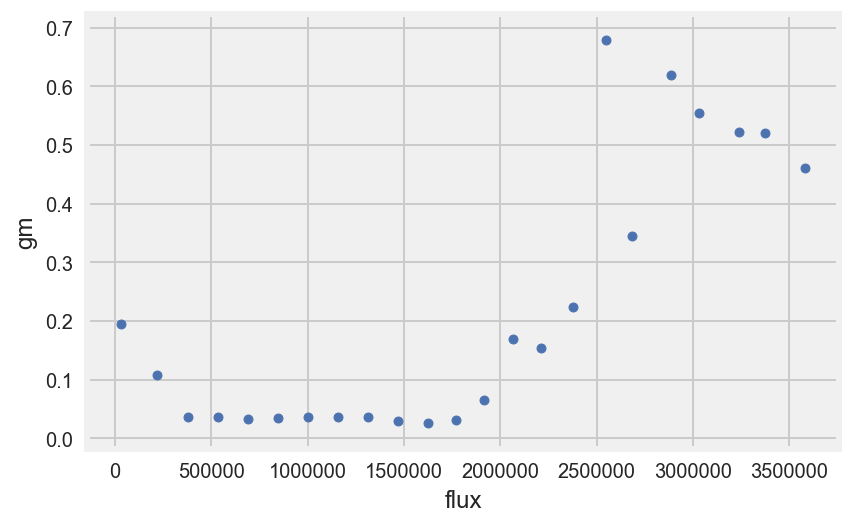

In [26]:
# we can see two data points are outer of 400k ie. 4e6
gm_gc_flux = gm_gc_flux.query('flux < 4e6')
gm_gc_flux.plot.scatter(x='flux',y='gm')

# Polynomial Fitting for gm vs flux after bucketing

array([  2.14277539e-44,  -2.26017752e-37,   8.47465320e-31,
        -1.27261270e-24,   3.69972668e-19,   8.66981617e-13,
        -7.91075360e-07,   2.24333979e-01])

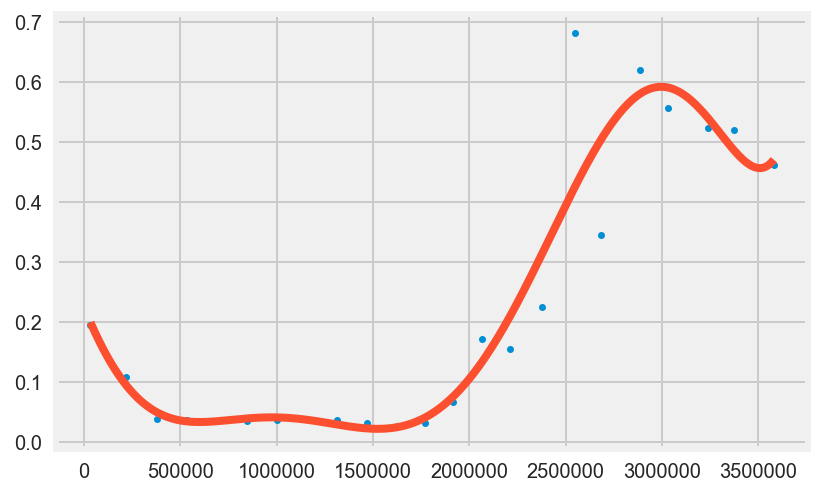

In [27]:
x = gm_gc_flux['flux'].values
y = gm_gc_flux['gm'].values

z = np.polyfit(x,y,DEGREE)
p = np.poly1d(z)
xp = np.linspace(x.min(), x.max(), 1000)
plt.plot(x, y, '.', xp, p(xp), '-')

gm_buckets = p.coeffs
gm_buckets

# Polynomial fitting for gc vs flux after bucketing

array([  2.11461600e-44,  -2.20487954e-37,   8.13633141e-31,
        -1.17803432e-24,   2.29105186e-19,   9.95074270e-13,
        -8.59831357e-07,   2.42492168e-01])

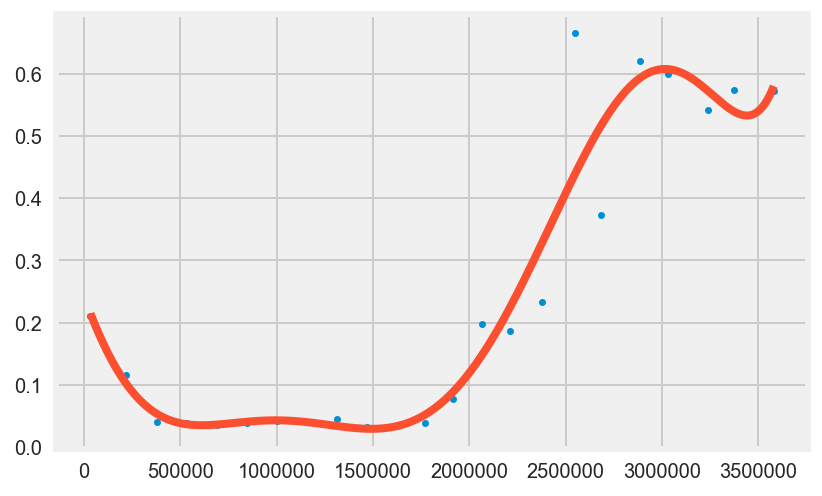

In [28]:
x = gm_gc_flux['flux'].values
y = gm_gc_flux['gc'].values

z = np.polyfit(x,y,DEGREE)
p = np.poly1d(z)
xp = np.linspace(x.min(), x.max(), 1000)
plt.plot(x, y, '.', xp, p(xp), '-')

gc_buckets = p.coeffs
gc_buckets

# Outputs

- number of buckets used = 30
- there are two flux values are are extremely high, which can be excluded.

In [29]:
import string

a = string.ascii_lowercase
a

'abcdefghijklmnopqrstuvwxyz'

In [30]:
parameters = pd.DataFrame({'gm_no_buckets': gm_no_buckets,
                          'gc_no_buckets': gc_no_buckets,
                          'gm_buckets': gm_buckets,
                          'gc_buckets': gc_buckets})


parameters

,gc_buckets,gc_no_buckets,gm_buckets,gm_no_buckets
0,2.114616e-44,3.705261e-44,2.142775e-44,3.618373e-44
1,-2.204880e-37,-5.106707e-37,-2.260178e-37,-4.989408e-37
2,8.136331e-31,2.664463e-30,8.474653e-31,2.605803e-30
3,-1.178034e-24,-6.585394e-24,-1.272613e-24,-6.452996e-24
4,2.291052e-19,7.872649e-18,3.699727e-19,7.747985e-18
5,9.950743e-13,-3.943334e-12,8.669816e-13,-3.933194e-12
6,-8.598314e-07,3.049392e-07,-7.910754e-07,3.482270e-07
7,2.424922e-01,2.049016e-01,2.243340e-01,1.875053e-01
